In [ ]:
#tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from keras import Model


import cv2

import sys
import numpy as np
import csv
import math

import os

import matplotlib.pyplot as plt

from keras.applications import MobileNetV2
from keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

### Import Dataset

In [42]:
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print ('Training data size:', train_images.shape, 'Test data size', test_images.shape)

# Normalize pixel values between 0 and 1
train_images = train_images / 255
test_images = test_images / 255

Training data size: (50000, 32, 32, 3) Test data size (10000, 32, 32, 3)


### Visualize dataset

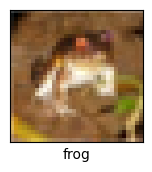

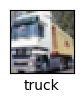

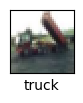

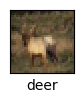

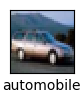

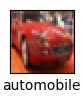

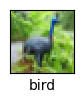

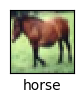

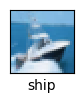

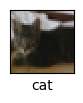

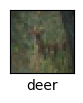

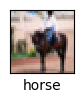

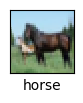

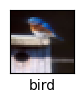

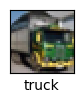

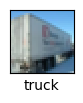

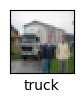

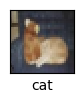

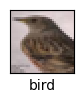

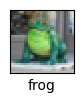

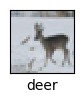

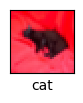

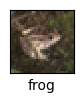

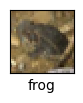

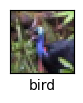

In [44]:
%matplotlib inline
#Show first 25 training images below
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
    plt.show()

### Resize images for use with MobileNetV2

In [46]:
# Upsize all training and testing images to 96x96 for use with mobile net
minSize = 96 #minimum size requried for mobileNetV2
train_image_size = 50000
test_image_size = 10000
# You may use cv2 package. Look for function:
#"cv2.resize(<originalImage>, dsize=(minSize, minSize), interpolation=cv2.INTER_AREA)"
# resize train image: You can first initialize a numpy array resized_train_images to store all the resized training images
resized_train_images = np.zeros((50000, minSize, minSize, 3), dtype=np.float32)
resized_test_images = np.zeros((10000, minSize, minSize, 3), dtype=np.float32)

for i in range(train_image_size):
    resized_train_images[i] = cv2.resize(train_images[i], (minSize, minSize), interpolation=cv2.INTER_AREA)

for i in range(test_image_size):
    resized_test_images[i] = cv2.resize(test_images[i], (minSize, minSize), interpolation=cv2.INTER_AREA)

### Download MobileNetV2 model



In [48]:
#<Write code for downloading MobileNetV2>
mobile_net_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
for layer in mobile_net_model.layers[:80]:
    layer.trainable=False

### Add custom layers at the end of downloaded model

In [ ]:
#<Write code for adding custom layers>
model = tf.keras.Sequential()
reg = regularizers.l2(0.01)
model.add(mobile_net_model)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu", kernel_regularizer=reg))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu", kernel_regularizer=reg))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation="relu", kernel_regularizer=reg))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation="softmax",kernel_regularizer=reg))

In [52]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 1280)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,627,722 (10.02 MB)

 Trainable params: 2,408,522 (9.19 MB)

 Non-trainable params: 219,200 (856.25 KB)

### Add loss function, compile and train the model, and check accuracy on test data

In [54]:
# optimizer=keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["sparse_categorical_accuracy"])

In [55]:
# ModelCheckpoint callback saves weights only during training
checkpoint_path = "training_1.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

#create callback
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

#create EarlyStopping callback to monitor accuracy. If accuracy exceeds 0.95, training stops immediately without going through any more epochs
early_stop = EarlyStopping(monitor="loss", verbose=1, mode='min', min_delta=1e-2, patience=3)


In [56]:
#load weights from previous training
weights_path = os.path.join(checkpoint_dir, "training_1.weights.h5")
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(weights_path)

In [57]:
epochs = 20
history = model.fit(resized_train_images, train_labels, epochs=epochs, callbacks=[cp_callback, early_stop], batch_size=32)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 3.7067 - sparse_categorical_accuracy: 0.6497
Epoch 1: saving model to training_1.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 238s 141ms/step - loss: 3.7056 - sparse_categorical_accuracy: 0.6497
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.7839 - sparse_categorical_accuracy: 0.8322
Epoch 2: saving model to training_1.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 89ms/step - loss: 0.7839 - sparse_categorical_accuracy: 0.8322
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.6829 - sparse_categorical_accuracy: 0.8537
Epoch 3: saving model to training_1.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 89ms/step - loss: 0.6829 - sparse_categorical_accuracy: 0.8537
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.6026 - sparse_categorical_accuracy: 0.8795
Epoch 4: saving model to training_1.weights.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - loss: 0.6026 - sparse_categorical

### Extra code for producing different plots

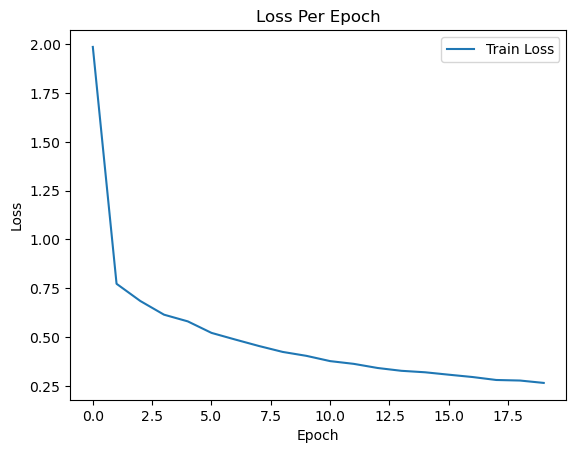

In [59]:
train_loss = history.history['loss']

#plot
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Per Epoch')
plt.legend()
plt.show()

### Accuracy of trained classifier over the test dataset (try to get >0.85) ###

In [62]:
test_loss, test_acc = model.evaluate(resized_test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 130ms/step - loss: 0.7147 - sparse_categorical_accuracy: 0.8710
